<center>
<img src="logo.png" height="900"> 
</center>


#  Временные ряды: SARIMA

В этой тетрадке мы продолжим знакомиться с моделями для прогнозирования временных рядов и поговорим про SARIMA. 

In [2]:
!pip install --ignore-installed sktime

  Using cached sktime-0.7.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.8 MB)
  Using cached statsmodels-0.12.2-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
  Using cached pandas-1.3.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (10.8 MB)
  Using cached numba-0.53.1-cp37-cp37m-manylinux2014_x86_64.whl (3.4 MB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached numpy-1.21.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached llvmlite-0.36.0-cp37-cp37m-manylinux2010_x86_64.whl (25.3 MB)
  Using cached setuptools-57.4.0-py3-none-any.whl (819 kB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Using cached scipy-1.7.0-cp37-cp37m-manylinux_2_5_x86

In [3]:
import numpy as np
import pandas as pd

from scipy import stats 
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns

%matplotlib inline

In [4]:
import warnings 
warnings.filterwarnings('ignore')

In [5]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Тест на стационарность

Чтобы бороться с нестационарностью, нужно знать её в лицо. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое. Попробуем сгенерировать несколько авторегрессий и проверить гипотезу о их стационарности: $y_t = \beta y_{t-1} + u_t$ 

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

def plotProcess(n_samples=1000, beta=0):
    y = u = np.random.normal(size=n_samples)
    for t in range(n_samples):
        y[t] = beta * y[t-1] + u[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(y)
        p_adf = round(adfuller(y)[1], 3)
        p_kpss = round(kpss(y)[1], 3)
        plt.title(f"Beta: {beta}\n Dickey-Fuller p-value: {p_adf} \n KPSS p-value: {p_kpss}")

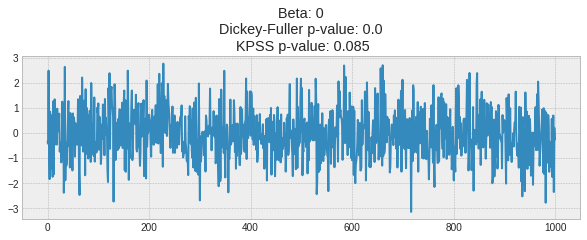

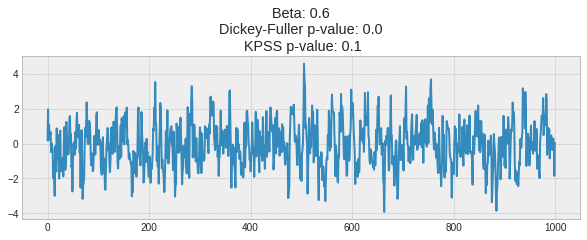

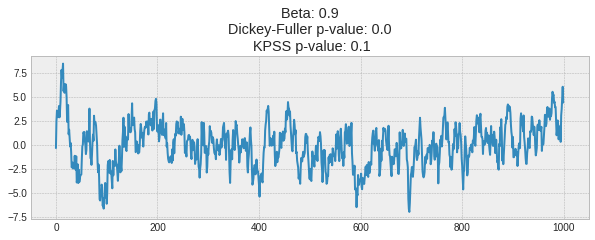

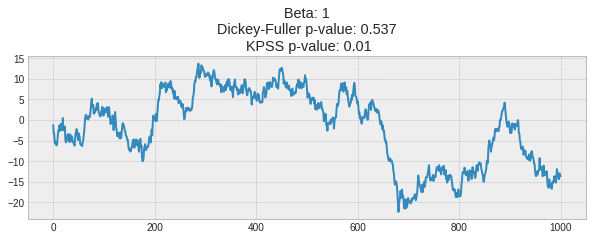

In [7]:
for beta in [0, 0.6, 0.9, 1]:
    plotProcess(beta=beta)

- На первом графике получился стационарный белый шум, последовательность из независимых нормальных случайных величин с нулевым математическим ожиданием и одинаковой дисперсией.
- На втором значение $\beta$ увеличилось до $0.6$, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. 
- Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. 
- Наконец, значение  равное единице дало процесс случайного блуждания — ряд не стационарен. Для него характеристики зависят от времени и мы подолгу задерживаемся по какую-то конкретную сторону от нуля. 

Нулевая гипотеза теста Дики-Фуллера — ряд не стационарен, отвергалась на первых трех графиках, и не отверглась на последнем. Для KPSS-теста, где нулевая гипотеза заключается в стационарности ряда, мы видим обратную картину. 

Если вычесть из левой и правой части $y_{t-1}$, то получим  $y_t - y_{t-1} = (\beta - 1) y_{t-1} + u_t$, где выражение слева — первые разности. Если $\beta=1$, то первые разности дадут стационарный белый шум $u_t$. Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. Это записывают как $y_t \sim I(1)$.

Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней). Здравый смысл подсказывает, что больше двух единичных корней не бывает. Так как первая разность - это приросты, а вторая ускорения (по аналогии с производными). Из-за этого в ряды $y_t \sim I(3)$ статистики не верят. 

При этом $y_t \sim I(2)$ ряды в рироде бывают. Один из примеров такого ряда - цены. Первая разность цен это инфляция, а ряд инфляции в теории считается нестационарным, так как может быть выражен через нестационарные процентные ставки. 

# 2. Данные


In [8]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time']).asfreq('H')
print(ads.shape)
ads.head()

(216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


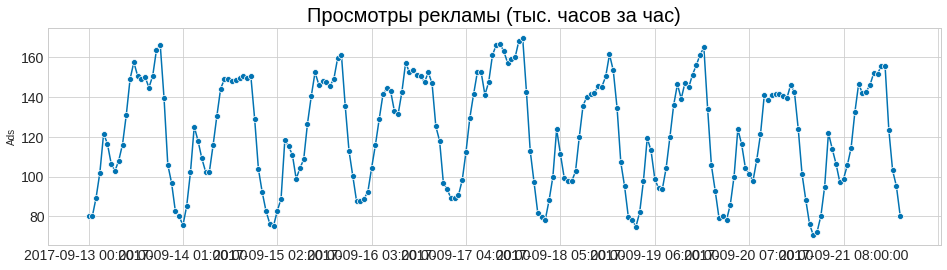

In [9]:
from sktime.utils.plotting import plot_series

y = ads.Ads/10**3  # в тысячах :)

plot_series(y)
plt.title('Просмотры рекламы (тыс. часов за час)', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

Тесты выдают не только `p_value`, но и расчитанные исследователями-создателями критические значения. У тестов нестандартные распределения. Число лагов для тестирования подбирается автоматически по информационному критерию. 

In [10]:
adfuller(y, regression='c', autolag='AIC')

(-7.089633890638522,
 4.4448036886221906e-10,
 9,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1447.702409531276)

In [11]:
kpss(y, regression='c')

(0.08515879435590198,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Обратите внимание, что тесты можно проводить против разных альтернатив, в зависимости от того, что мы видим в данных: 

```
    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "nc" : no constant, no trend.
```

В данном случае мы видим только константу, так как ряд колеблется вокруг ненулевого среднего. Посмотрим на ещё один ряд. 

(300, 1)


<Figure size 1080x432 with 0 Axes>

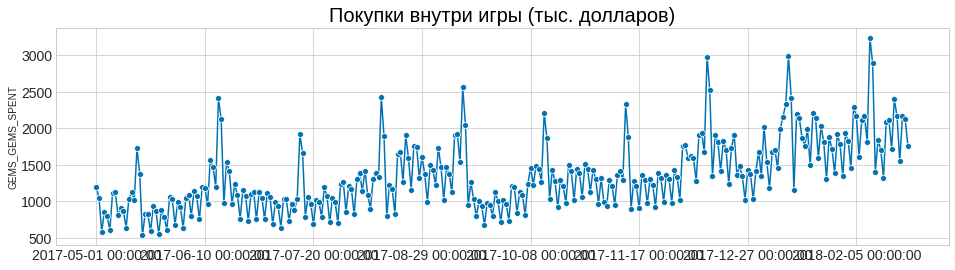

In [12]:
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])
print(currency.shape)

plt.figure(figsize=(15, 6))
z = currency.GEMS_GEMS_SPENT/10**3  # в тысячах :)

plot_series(z)
plt.title('Покупки внутри игры (тыс. долларов)', fontsize=20, color='black')
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);

Тут в ряде заметны тренд и константа. Поэтому мы выбираем в качестве базовой другую модель. 

In [13]:
adfuller(y, regression='ct', autolag='AIC')

(-7.2876873847653565,
 3.1289817312819063e-09,
 9,
 206,
 {'1%': -4.003402336644926,
  '5%': -3.4320207442298027,
  '10%': -3.1396965086430555},
 1447.5157288829562)

Видим, что ряд стационарен. Если выбрать неверную спецификацию теста, можно ошибиться с выводами: 

In [14]:
adfuller(y, regression='nc', autolag='AIC')

(-0.6216993344800485,
 0.44553886731968273,
 12,
 203,
 {'1%': -2.5768418078575066,
  '5%': -1.9424010772432776,
  '10%': -1.6155744530123806},
 1482.4285026259213)

# 3. Автоарима

Попробуем оценить на наших данных SARIMA-модель. Делать это будем в рамках [пакета `pmdarima`](https://alkaline-ml.com/pmdarima/user_guide.html)

168 48


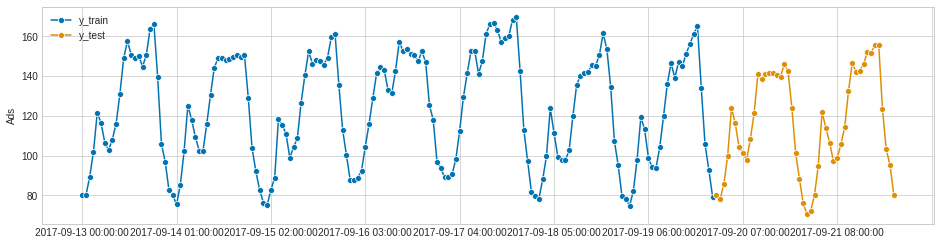

In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y_train, y_test = temporal_train_test_split(y, test_size=48)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [ ]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.auto_arima(
    
    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=24,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
    
    # Можно делать перебор гипер-параметров 
    # на основе метрики на тестовой выборке
    #scoring='mae',
)

 ARIMA(0,0,0)(0,0,0)[24] intercept   : BIC=1600.196, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : BIC=1499.817, Time=58.28 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : BIC=inf, Time=493.70 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : BIC=inf, Time=125.60 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : BIC=inf, Time=100.90 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : BIC=inf, Time=803.80 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : BIC=inf, Time=659.70 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : BIC=inf, Time=688.10 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : BIC=inf, Time=888.10 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : BIC=1434.233, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : BIC=1350.698, Time=77.50 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : BIC=1319.072, Time=575.00 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : BIC=1268.207, Time=163.60 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : BIC=1316.875, Time=188.00 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : BIC=inf, Time=1063.60 sec
 ARIMA(0,0

In [ ]:
print(arima_model.summary())

In [ ]:
y_pred, pred_ci = arima_model.predict(
    n_periods=48, 
    return_conf_int=True, 
    alpha=0.05
)

mape(y_pred, y_test)

In [ ]:
df_forecast = pd.DataFrame({'y_pred': y_pred, 'ci_lower': pred_ci[:,0], 'ci_upper': pred_ci[:,1]})
df_forecast.index = fh
df_forecast.head()

In [ ]:
fig, ax = plot_series(y_train, y_test, df_forecast.y_pred, labels=["y_train", "y_test", "y_pred"]);
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["ci_lower"],
    df_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

Посмотрим на графики для диагностики модели. Автокорреляций нет, математическое ожидание равно нулю. Дисперсия постоянна. Распределение остатков нормально. Приятно. 

In [ ]:
arima_model.plot_diagnostics(figsize=(10, 8));

На самом деле ровно эта же модель вшита в пакет `sktime`, но в урезанном виде. Напомню, что этот пакет только разрабатывается и его великое будущее впереди. 

# 4. Трансформация данных 

В рамках пакета можно делать трансформацию данных и собирать пайплайны также, как и в sklearn. Например, перед обучением модели можно сделать преобразование Бокса-Кокса. Его здесь обычно используют для того, чтобы стабилизировать дисперсию остатков и сделать их нормальными. 

In [ ]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA(seasonal=True, suppress_warnings=True))
])

pipeline.fit(y_train)
pipeline.predict(5)

In [ ]:
pipeline.steps[1][1].summary()

## Материалы: 

- [Документация пакета pmdarima с примерами использования](https://alkaline-ml.com/pmdarima/quickstart.html)
- [Гайд по ARIMA от statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)